In [1]:
#Import Required Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pandas import ExcelWriter
from pandas import ExcelFile
import glob
from termcolor import colored

from pathlib import Path
from trc2csv import convert_trc_to_csv
%matplotlib inline

In [2]:
column_types = {'Time': float,
            'Type': str,
            'ID': str,
            'Data Length': int,
            'Data0': str, 
            'Data1': str, 
            'Data2': str, 
            'Data3': str, 
            'Data4': str, 
            'Data5': str, 
            'Data6': str, 
            'Data7': str, 
            }

In [45]:
def read_data(filename, label):
    df = pd.read_csv(filename, dtype=column_types)
    df = df.sort_values(by=['Time'])
    df = df.drop_duplicates(keep='first')
    df['Time_Gap'] = df['Time'].diff(1)
    df['Label'] = label
    return df

In [46]:
files = [
    ('Normal', '../Data/LISA/csv/KIA/20220310/20220310_C-CAN_구쏘울_정상.csv'),
    ('DoS', '../Data/LISA/csv/KIA/DoS_Soul.csv'),
    ('Fuzzy', '../Data/LISA/csv/KIA/fuzzing_-_Soul.csv'),
    ('Replay', '../Data/LISA/csv/KIA/REPLAY_-_Soul.csv'),
    # ('DoS', './datasets/csv/KIA/20220310/20220310_C-CAN_구쏘울_DoS_10000.csv'),
    # ('Replay', './datasets/csv/KIA/20220310/20220310_C-CAN_구쏘울_Replay_2.csv')
]
df_dict = dict(map(lambda x: (x[0], read_data(x[1], x[0])), files))
print(len(df_dict))

4


In [63]:
(df_dict['Normal']['Time'].max() - df_dict['Normal']['Time'].min()) / 1000

624.4945

In [47]:
df = pd.concat(df_dict.values())
df

,Time,Type,ID,Data Length,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Time_Gap,Label
0,1.7,Rx,02B0,5,05,07,00,07,AF,NaN,NaN,NaN,NaN,Normal
1,2.0,Rx,0165,8,84,B7,81,00,00,00,0F,BD,0.3,Normal
2,3.1,Rx,0153,8,00,80,10,FF,00,FF,60,EE,1.1,Normal
3,3.3,Rx,01F1,8,00,35,2D,20,03,2C,10,03,0.2,Normal
4,3.6,Rx,0220,8,16,0C,38,24,0C,10,A1,12,0.3,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266831,592811.0,Rx,0329,8,40,B0,80,8C,12,2E,00,10,0.3,Replay
1266832,592811.2,Rx,0370,8,FF,26,10,88,FF,00,00,B0,0.2,Replay
1266833,592811.4,Rx,0392,8,06,91,08,5B,00,C6,00,C0,0.2,Replay
1266834,592811.7,Rx,0018,8,00,00,00,60,00,00,20,00,0.3,Replay


In [62]:
df.groupby(['Label'])['Time'].count()

Label
DoS       1174331
Fuzzy     1145910
Normal    1303127
Replay    1266836
Name: Time, dtype: int64

In [52]:
df_dict['Fuzzy']['Time_Gap'].argmin()

141917

In [53]:
df_dict['Fuzzy'].iloc[141916:141918]

,Time,Type,ID,Data Length,Data0,Data1,Data2,Data3,Data4,Data5,Data6,Data7,Time_Gap,Label
142293,66405.8,Rx,00A7,8,DF,40,A8,93,A7,3A,D2,37,0.1,Fuzzy
142292,66405.8,Rx,0081,8,80,34,62,00,00,00,00,DC,0.0,Fuzzy


In [51]:
def q1(x): return x.quantile(0.25)
def q4(x): return x.quantile(0.75)
df.groupby(['Label'])['Time_Gap'].agg(['min', 'max', 'mean', 'std'])

,min,max,mean,std
Label,,,,
DoS,0.0,10.7,0.471948,0.648586
Fuzzy,0.0,2601.6,0.460046,2.516926
Normal,0.1,4.9,0.479228,0.681490
Replay,0.1,4.9,0.467946,0.652208


In [29]:
time_group = df.groupby(['Label'])['Time'].agg(['min','max'])
time_group['duration'] = time_group['max'] - time_group['min']
time_group

,min,max,duration
Label,,,
DoS,4.5,554227.3,554222.8
Fuzzy,3.7,527174.3,527170.6
Normal,1.7,624496.2,624494.5
Replay,2.1,592811.9,592809.8


<AxesSubplot:xlabel='Label', ylabel='Time_Gap'>

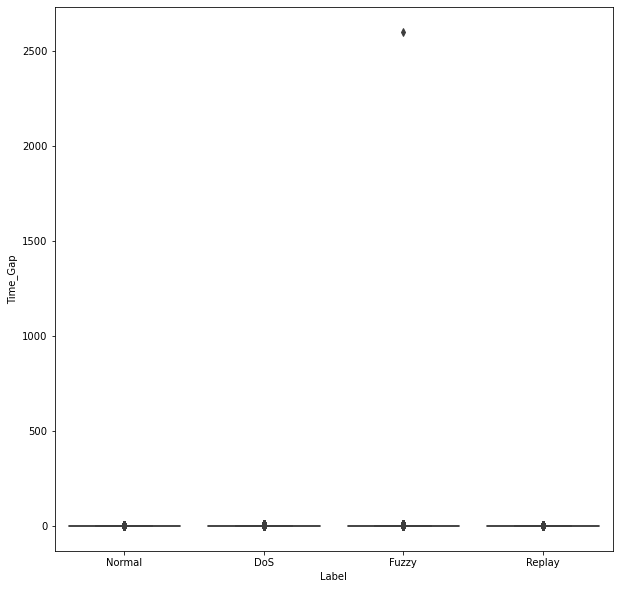

In [121]:
plt.figure(figsize=(10, 10))
sns.boxplot(x = 'Label', y="Time_Gap", data = df)

In [119]:
dt = df[df.Label == 'DoS']
dt.loc[dt.index[dt['Time_Gap'] > 10]][['Time', 'Time_Gap']]

,Time,Time_Gap
297609,123341.6,10.4
297625,123411.2,10.1
300281,125341.2,10.3
300307,125461.2,10.3
300315,125491.0,10.3
...,...,...
825072,319726.3,10.2
825084,319776.4,10.2
826488,320655.9,10.1
826496,320686.3,10.1


In [34]:
print(*(f'{name} : {len(data["ID"].unique())}\n' for name, data in df_dict.items()))

Normal : 45
 DoS : 212
 Fuzzy : 320
 Replay : 46



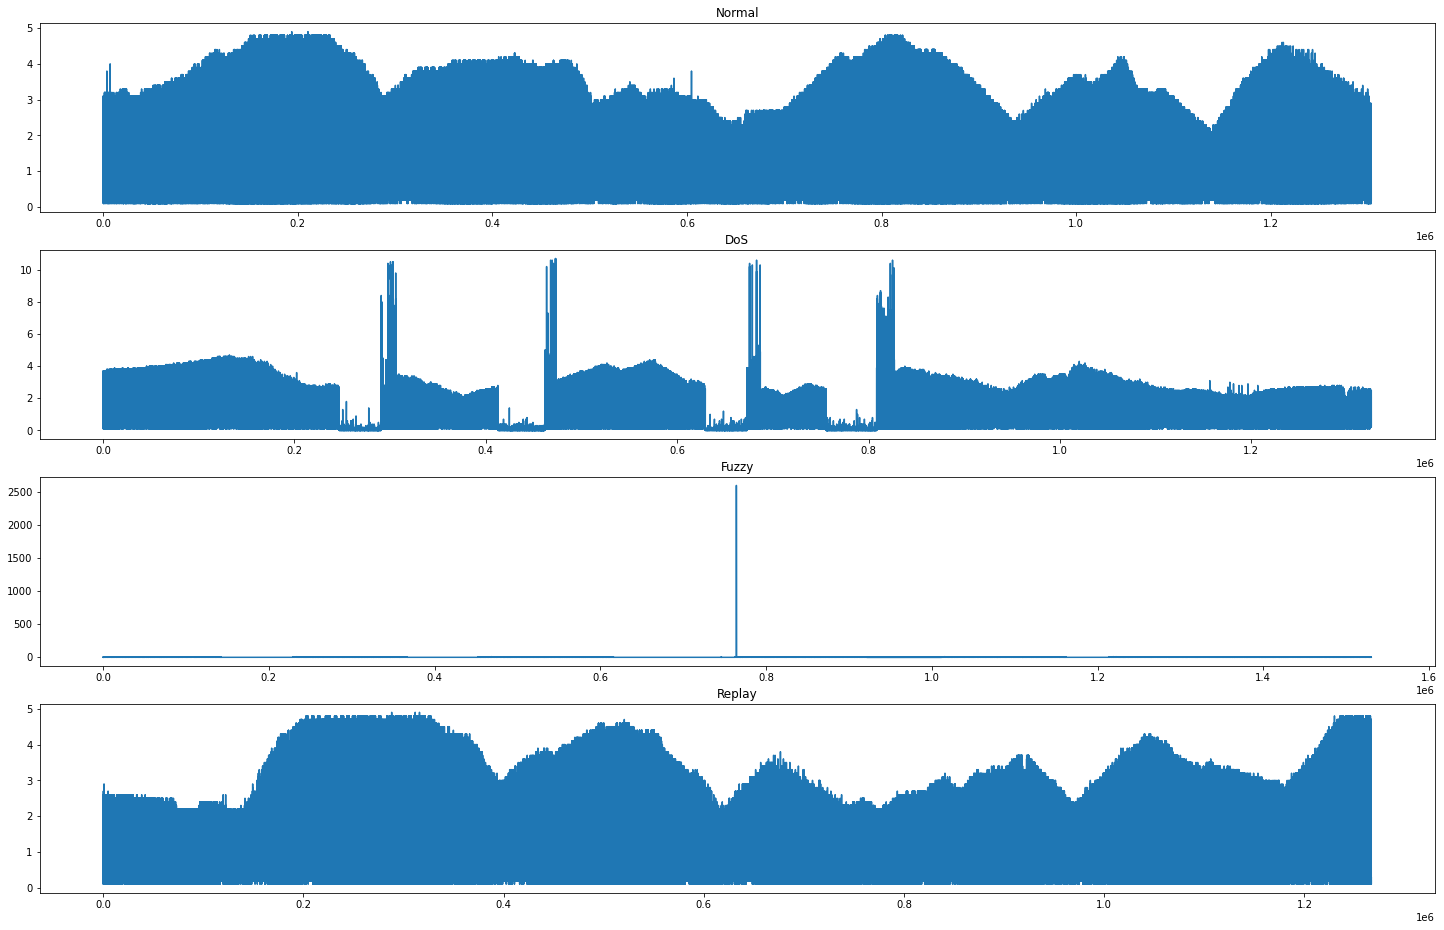

In [21]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(25, 16))
for i, (name, data) in enumerate(df_dict.items()):
    ax[i].plot(data['Time_Gap'][:])
    ax[i].set_title(name)

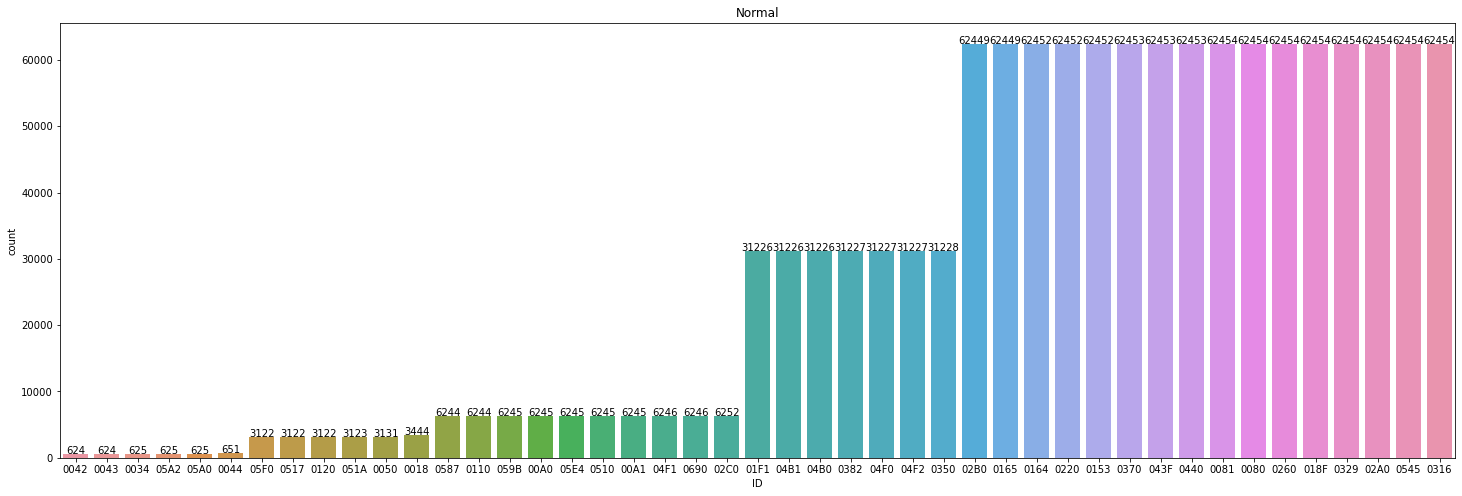

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 8))
# for i, (name, data) in enumerate(df_dict.items()):
i = 0
name = 'Normal'
data = df_dict['Normal']
order = data['ID'].value_counts().sort_index().sort_values().index
sub_ax = sns.countplot(x="ID", data=data, order = order, ax=ax)
sub_ax.set_title(name)
for p in sub_ax.patches:
    sub_ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()+3000), ha='center', va='top', color='black', size=10)